In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import time
from alive_progress import alive_bar

from global_search_recommendation.BioInspiredRecomendation import BioInspiredRecomendation
from global_search_recommendation.dominio import Dominio
from percentile_recommendation.current_calculator import RecommendationCalculator
from SheetsConversor import SheetsConversor
from Complete import CompleteCalculator
from commons.Tariff import BlueTariff, GreenTariff

In [2]:
conversor = SheetsConversor('../sheets-plus/')
ucs, mods, contract = conversor.convert()

Reading ../sheets-plus/UFPR.xlsx...
Reading ../sheets-plus/UFMG_II.xlsx...
Reading ../sheets-plus/UFRA.xlsx...
Reading ../sheets-plus/UFMG_I.xlsx...
Reading ../sheets-plus/UFFS.xlsx...
Reading ../sheets-plus/UFAL.xlsx...
Reading ../sheets-plus/UFSJ.xlsx...
Reading ../sheets-plus/UFCA.xlsx...
Reading ../sheets-plus/UFJF.xlsx...
Reading ../sheets-plus/UFOP.xlsx...
Reading ../sheets-plus/UFMS.xlsx...
Reading ../sheets-plus/UFRGS.xlsx...
Done! 130 UCs conveted!


In [3]:
def do_percentile_complete(n: int):
    results = {}

    with alive_bar(len(ucs), force_tty=True) as bar:
        for k in ucs:
            cm = RecommendationCalculator(ucs[k].head(n), mods[k], BlueTariff(), GreenTariff(), n)
            complete_calculator = CompleteCalculator(n, ucs[k])
    
            result = {'percentil':cm.calculate(partial=True),
                      'completo':complete_calculator.run(partial=True)}
    
            results[k] = result
            bar()
            
    return results

In [4]:
ROUNDS = 10 # Quantidade de vezes que os global-search serão executados para a mesma uc

def pso_ga(n: int, results, pop):
    ret = {}

    with alive_bar(len(ucs), force_tty=True) as bar:
        for k in ucs:
            bio_inspired = BioInspiredRecomendation(n, pd.DataFrame(ucs[k]), num_pop = pop)

            pso_accum = {'green': [0, 0], 'blue': [0, 0, 0], 'time':.0}
            ga_accum = {'green': [0, 0], 'blue': [0, 0, 0], 'time':.0}

            cp_green = results[k]['completo']['green']
            cp_blue = results[k]['completo']['blue']

            for _ in range(ROUNDS):
                pso = bio_inspired.do_PSO(iterative=True, partial=True)
                ga = bio_inspired.do_GA(iterative=True, partial=True)
                
                pso_accum['green'][0] += rel_acur(pso['green'][0], cp_green[0])
                pso_accum['green'][1] += rel_acur(pso['green'][1], cp_green[1])
                pso_accum['blue'][0] += rel_acur(pso['blue'][0], cp_blue[0])
                pso_accum['blue'][1] += rel_acur(pso['blue'][1], cp_blue[1])
                pso_accum['blue'][2] += rel_acur(pso['blue'][2], cp_blue[2])
                pso_accum['time'] += pso['time']
                
                ga_accum['green'][0] += rel_acur(ga['green'][0], cp_green[0])
                ga_accum['green'][1] += rel_acur(ga['green'][1], cp_green[1])
                ga_accum['blue'][0] += rel_acur(ga['blue'][0], cp_blue[0])
                ga_accum['blue'][1] += rel_acur(ga['blue'][1], cp_blue[1])
                ga_accum['blue'][2] += rel_acur(ga['blue'][2], cp_blue[2])
                ga_accum['time'] += ga['time']

            pso_avg = {key: [x / ROUNDS for x in value] for key, value in list(pso_accum.items())[:-1]}
            ga_avg = {key: [x / ROUNDS for x in value] for key, value in list(ga_accum.items())[:-1]}

            pso_avg['time'] = pso_accum['time']/ROUNDS
            ga_avg['time'] = ga_accum['time']/ROUNDS
            
            ret[k] = {'pso': pso_avg, 'ga': ga_avg}
            bar()

    return ret

In [5]:
def rel_acur(val, target):

    return 1 - abs(target - val)/target

In [6]:
def calculate_std_dev(numbers):
    numbers = np.array(numbers)
    
    mean = np.mean(numbers)

    variance = np.mean((numbers - mean) ** 2)
    
    std_dev = np.sqrt(variance)
    
    return std_dev

In [7]:
def get_method_demand_correctness_(r1, r2):
    headers = ['percentil', 'pso', 'ga', 'Completo']

    peak_demands = pd.DataFrame(columns=headers)
    off_peak_demands = pd.DataFrame(columns=headers)
    unique_demands = pd.DataFrame(columns=headers)

    for uc in ucs:
        peak_demands.loc[len(peak_demands)] = [r1[uc]['percentil']['blue'][0], r2[uc]['pso']['blue'][0], r2[uc]['ga']['blue'][0], r1[uc]['completo']['blue'][0]]
        off_peak_demands.loc[len(off_peak_demands)] = [r1[uc]['percentil']['blue'][1], r2[uc]['pso']['blue'][1], r2[uc]['ga']['blue'][1], r1[uc]['completo']['blue'][1]]
        unique_demands.loc[len(unique_demands)] = [r1[uc]['percentil']['green'][0], r2[uc]['pso']['green'][0], r2[uc]['ga']['green'][0], r1[uc]['completo']['green'][0]]
        
    ret, dev = [], {}
    i = 0

    ret.append(
            [
                100 * round(rel_acur(peak_demands.Completo, peak_demands['percentil']).sum()/len(peak_demands), 4),
                100 * round(rel_acur(off_peak_demands.Completo, off_peak_demands['percentil']).sum()/len(off_peak_demands), 4),
                100 * round(rel_acur(unique_demands.Completo, unique_demands['percentil']).sum()/len(unique_demands), 4)
            ]
        )

    dev.update({
        'percentil':[calculate_std_dev(rel_acur(peak_demands.Completo, peak_demands['percentil'])), 
                     calculate_std_dev(rel_acur(off_peak_demands.Completo, off_peak_demands['percentil'])), 
                     calculate_std_dev(rel_acur(unique_demands.Completo, unique_demands['percentil']))
                    ]
    })
    
    for h in headers:
        if i in [0, 3]:
            i+=1
            continue

        ret.append(
            [
                100 * round(peak_demands[h].sum()/len(peak_demands), 4),
                100 * round(off_peak_demands[h].sum()/len(off_peak_demands), 4),
                100 * round(unique_demands[h].sum()/len(unique_demands), 4)
            ]
        )

        dev.update({
            h:[calculate_std_dev(peak_demands[h]), calculate_std_dev(off_peak_demands[h]), calculate_std_dev(unique_demands[h])]
        })
        
        i+=1
    return ret, dev

In [8]:
def get_method_value_correctness_(r1, r2):
    headers = ['percentil', 'pso', 'ga', 'Completo']

    blue_values = pd.DataFrame(columns=headers)
    green_values = pd.DataFrame(columns=headers)
   
    for uc in ucs:
        blue_values.loc[len(blue_values)] = [r1[uc]['percentil']['blue'][2], r2[uc]['pso']['blue'][2], r2[uc]['ga']['blue'][2], r1[uc]['completo']['blue'][2]]
        green_values.loc[len(green_values)] = [r1[uc]['percentil']['green'][1], r2[uc]['pso']['green'][1], r2[uc]['ga']['green'][1], r1[uc]['completo']['green'][1]]

    ret, dev = [], []
    i = 0

    ret.append(
            [
                100 * round(rel_acur(blue_values.Completo, blue_values['percentil']).sum()/len(blue_values), 4),
                100 * round(rel_acur(green_values.Completo, green_values['percentil']).sum()/len(green_values), 4)
            ]
        )

    dev.append(
        [
            calculate_std_dev(rel_acur(blue_values.Completo, blue_values['percentil']).values), 
            calculate_std_dev(rel_acur(green_values.Completo, green_values['percentil']).values)
        ]) 
    
    for h in headers:
        if i in [0, 3]:
            i+=1
            continue

        ret.append(
            [
                100 * round(blue_values[h].sum()/len(blue_values), 4),
                100 * round(green_values[h].sum()/len(green_values), 4)
            ]
        )

        dev.append([calculate_std_dev(blue_values[h].values), calculate_std_dev(green_values[h].values)])
        
        i+=1
    return ret, dev

In [9]:
def get_times(r):
    headers = ['pso', 'ga']

    times = pd.DataFrame(columns=headers)

    for uc in ucs:
        times.loc[len(times)] = [r[uc]['pso']['time'], r[uc]['ga']['time']]

    print(f"\tPSO: {times['pso'].mean()} GA: {times['ga'].mean()}")

In [18]:
def plot_correctness_(num_months, n):
    m = num_months
    i = 6
    results = correctness_demands_results_ if n == 3 else correctness_values_results_
    data = {'Percentil':results[m-i][0], 'PSO':results[m-i][1], 'GA':results[m-i][2]}

    x = np.arange(n)
    width = 0.25  
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    labels = ['Ponta', 'Fora de ponta', 'Única'] if n == 3 else ['Azul', 'Verde']

    for method, measures in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measures, width, label=method)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylabel('Taxa de acerto (%)')
    ax.set_xlabel('Posto Tarifário' if n == 3 else 'Modalidade Tarifária')
    ax.set_title(f'Usando {m} meses de histórico')
    ax.set_xticks(x + width, labels)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 120)

    plt.show()

In [11]:
warnings.filterwarnings('ignore')

percent_complete_results = []
print("Percentile and complete")
for n in range(6, 13):
    print(f"Calculating to {n} months...", flush=True)
    percent_complete_results.append(do_percentile_complete(n))

deterministic_results = { 6+i:percent_complete_results[i] for i in range(0, 7) }
#print(deterministic_results)

Percentile and complete
Calculating to 6 months...
|████████████████████████████████████████| 130/130 [100%] in 8:04.3 (0.26/s)    
Calculating to 7 months...
|████████████████████████████████████████| 130/130 [100%] in 9:20.9 (0.23/s)    
Calculating to 8 months...
|████████████████████████████████████████| 130/130 [100%] in 9:44.3 (0.22/s)    
Calculating to 9 months...
|████████████████████████████████████████| 130/130 [100%] in 9:34.0 (0.22/s)    
Calculating to 10 months...
|████████████████████████████████████████| 130/130 [100%] in 10:22.6 (0.20/s)   
Calculating to 11 months...
|████████████████████████████████████████| 130/130 [100%] in 11:39.1 (0.18/s)   
Calculating to 12 months...
|████████████████████████████████████████| 130/130 [100%] in 11:28.4 (0.19/s)    ▂▂▄ 81/130 [62%] in 1:14 (~45s, 1.1/s


In [12]:
warnings.filterwarnings('ignore')

pso_ga_ = {}
print("Global-search POP = 10")
for n in range(6, 13):
    print(f"Calculating to {n} months...", flush=True)
    pso_ga_.update({n:pso_ga(n, deterministic_results[n], 10)})

Global-search POP = 10
Calculating to 6 months...
|████████████████████████████████████████| 130/130 [100%] in 2:14.6 (0.96/s)    
Calculating to 7 months...
|████████████████████████████████████████| 130/130 [100%] in 2:20.9 (0.92/s)    
Calculating to 8 months...
|████████████████████████████████████████| 130/130 [100%] in 2:42.3 (0.80/s)    
Calculating to 9 months...
|████████████████████████████████████████| 130/130 [100%] in 2:53.8 (0.75/s)    
Calculating to 10 months...
|████████████████████████████████████████| 130/130 [100%] in 3:07.4 (0.69/s)    
Calculating to 11 months...
|████████████████████████████████████████| 130/130 [100%] in 3:02.8 (0.71/s)    
Calculating to 12 months...
|████████████████████████████████████████| 130/130 [100%] in 3:16.9 (0.66/s)    


Deviation
{'percentil': [0.2612436640212267, 0.07797608317540679, 0.08254987370265397], 'pso': [0.009463613055146175, 0.006895241893669907, 0.002173722615465346], 'ga': [0.018499767075364285, 0.02228473243925313, 0.011457268122561582]}
Deviation
{'percentil': [0.046131346324650255, 0.01962876020479612, 0.028026138928113828], 'pso': [0.0061154621637111465, 0.00862591080877098, 0.0014287727372154604], 'ga': [0.020040519766795512, 0.0164705126918513, 0.012614478290525567]}
Deviation
{'percentil': [0.0232700790989703, 0.01930554772238264, 0.02270769036936394], 'pso': [0.004382607516583832, 0.00895787070021196, 0.0008684838534543078], 'ga': [0.017428169478106856, 0.04769009784703342, 0.014611958871454804]}
Deviation
{'percentil': [0.042339038725206585, 0.09687654437685068, 0.04626301859996287], 'pso': [0.004535342755225635, 0.011325758256339821, 0.006198782586485088], 'ga': [0.018241516179621577, 0.022517822608062708, 0.012735465851814334]}
Deviation
{'percentil': [0.04496507243836643, 0.02

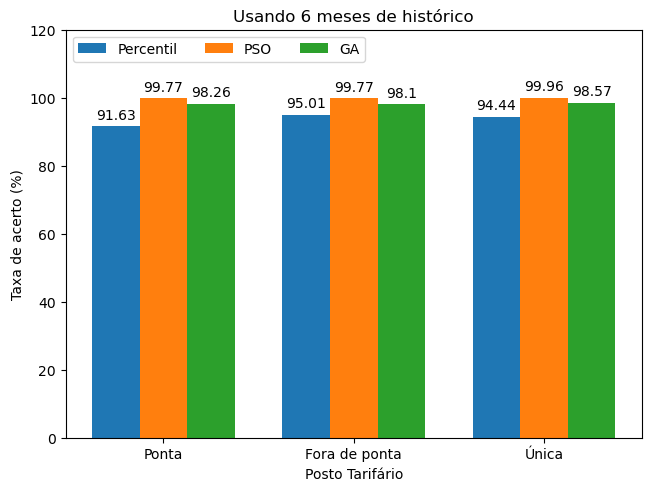

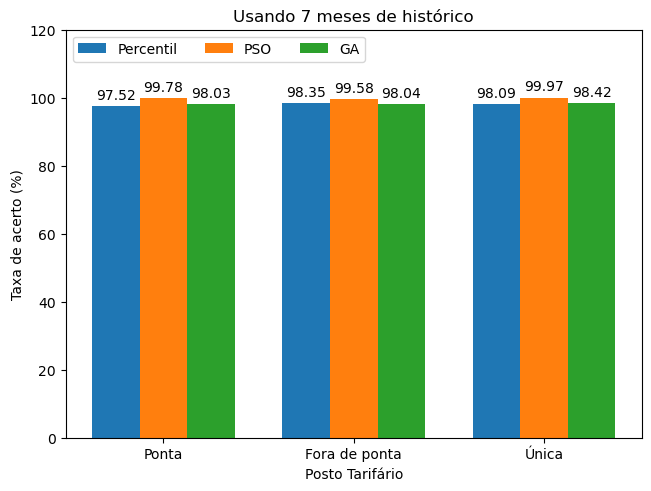

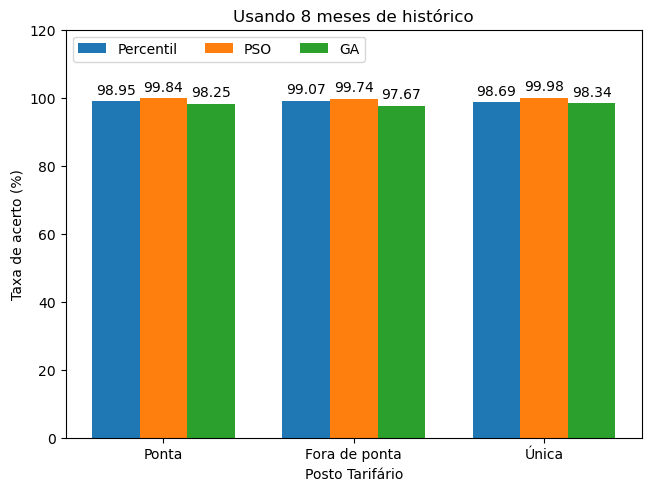

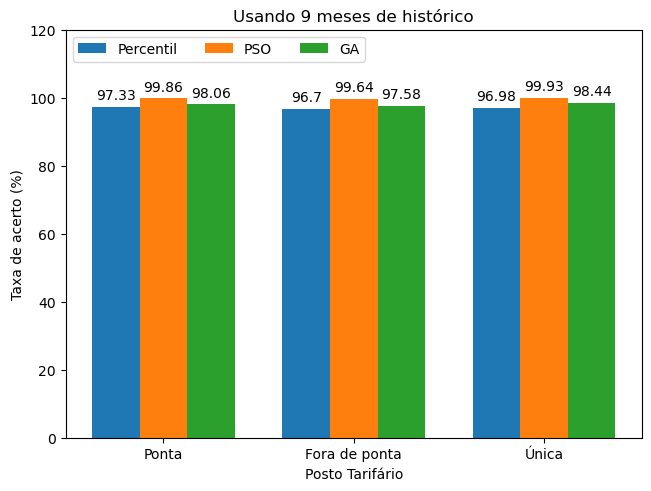

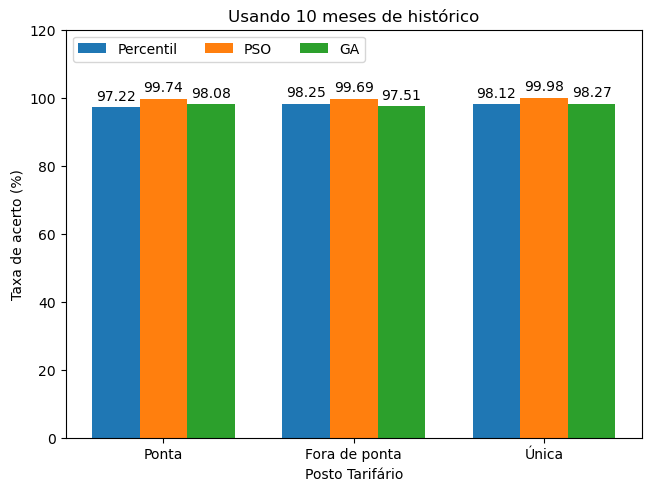

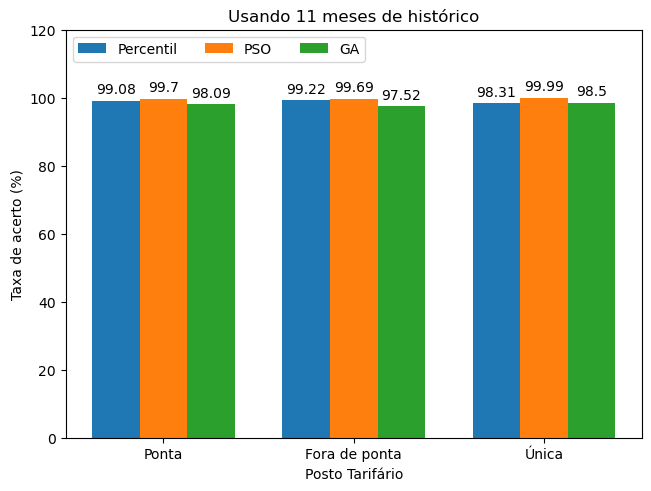

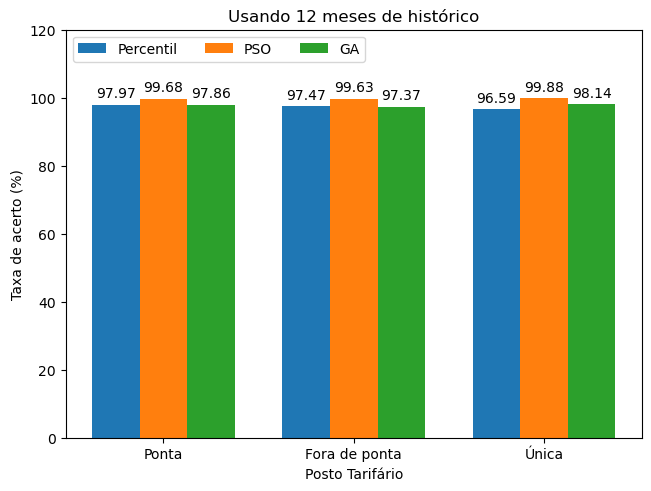

In [19]:
correctness_demands_results_ = []
for d, s in zip(deterministic_results, pso_ga_):
    r1 = deterministic_results[d]
    r2 = pso_ga_[s]
    ret, dev = get_method_demand_correctness_(r1, r2)
    correctness_demands_results_.append(ret)

    print("Deviation")
    print(dev)

for i in range(6, 13):
    plot_correctness_(i, 3)

Deviations
[[0.00022003719429642722, 0.004001428844453142], [0.0006537063778290901, 0.00011655103577839425], [0.002218536369005776, 0.0009119518733476378]]
Deviations
[[0.0009816967240577127, 0.004024764450077092], [0.0009765907191308615, 0.00010861061879118243], [0.0022467113552190865, 0.0009978085419874107]]
Deviations
[[0.0006725700856669716, 0.003662804284093914], [0.0010146314511889042, 8.900108839621935e-05], [0.0039234358703569075, 0.0011390705071795781]]
Deviations
[[0.0004280323766016251, 0.003652608445080967], [0.00127704211739111, 5.6846404581328066e-05], [0.002089214376091704, 0.0010464889089441304]]
Deviations
[[0.0008283664124205708, 0.0031020640700134476], [0.0008713032370291662, 6.987362851169404e-05], [0.002470129737434448, 0.00190111420578175]]
Deviations
[[0.00043234752565873586, 0.0026406713440347623], [0.0014452982045290645, 7.471092140332062e-05], [0.002806464467652735, 0.00104159555066949]]
Deviations
[[0.0003299235997107238, 0.0030539085221873395], [0.0018364627

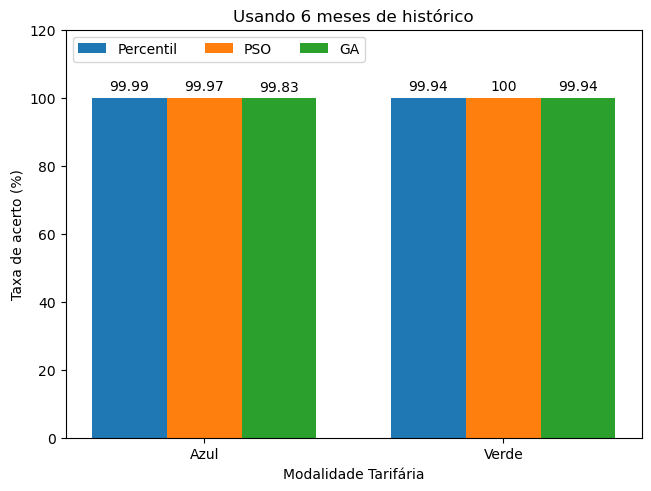

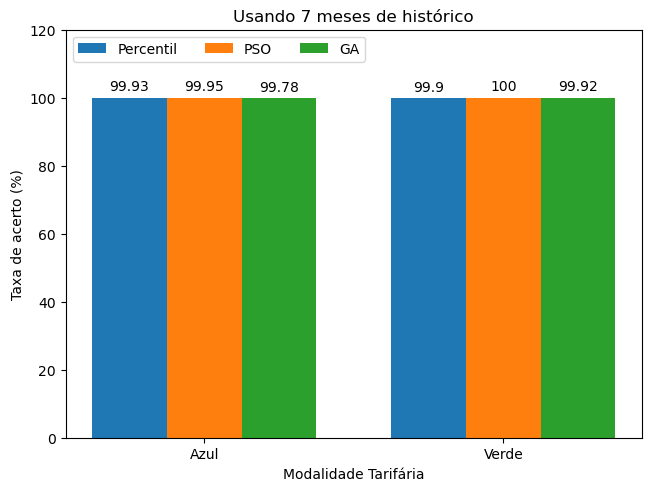

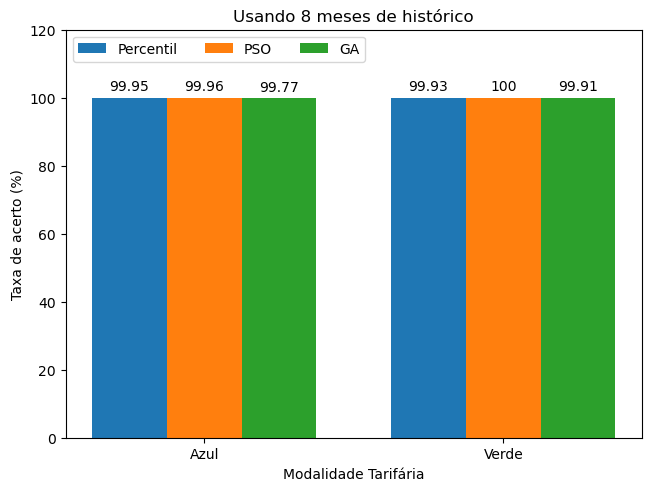

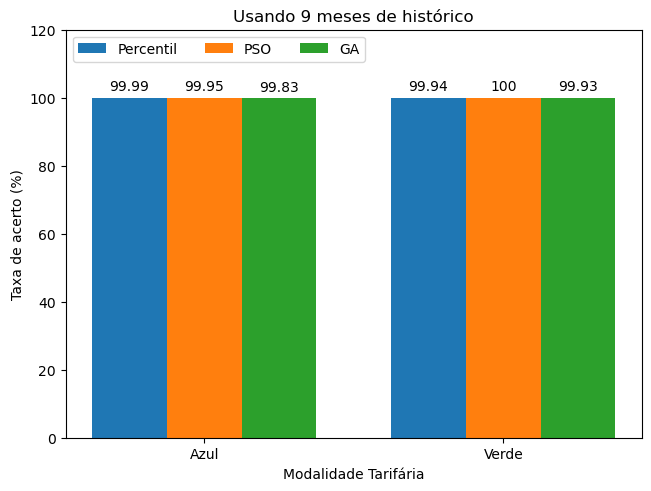

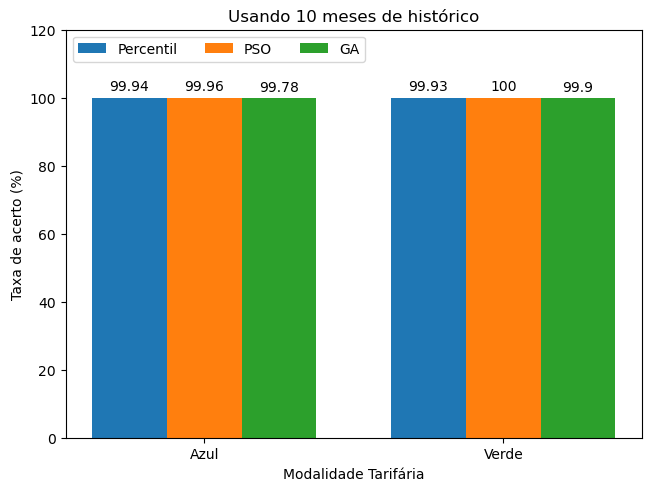

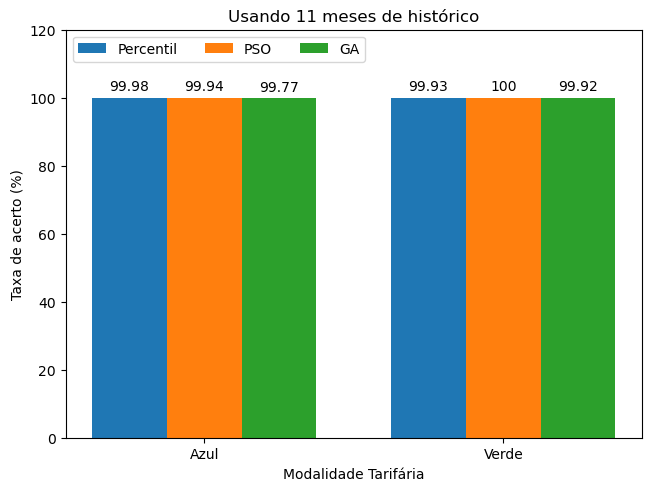

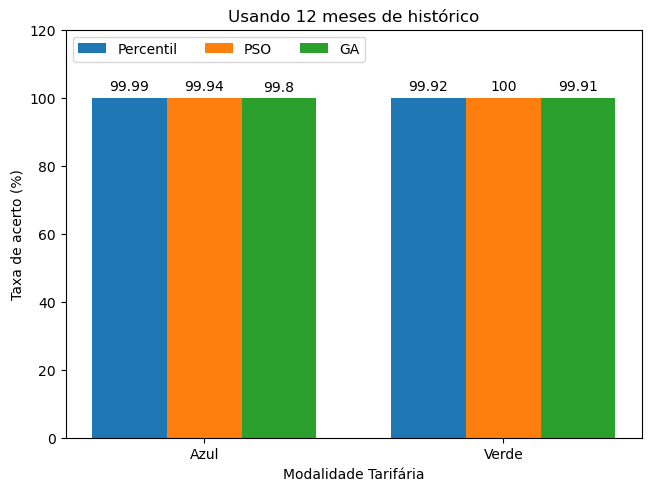

In [21]:
correctness_values_results_ = []
for d, s in zip(deterministic_results, pso_ga_):
    r1 = deterministic_results[d]
    r2 = pso_ga_[s]
    ret, dev = get_method_value_correctness_(r1, r2)
    correctness_values_results_.append(ret)

    print("Deviations")
    print(dev)

for i in range(6, 13):
    plot_correctness_(i, 2)

In [22]:
for n in range(6, 13):
    print(f"\nUsing {n} months (seconds)")
    get_times(pso_ga_[n])


Using 6 months (seconds)
	PSO: 0.055433342090019815 GA: 0.04787595473803007

Using 7 months (seconds)
	PSO: 0.059982184079977185 GA: 0.04807519600941585

Using 8 months (seconds)
	PSO: 0.06824953904518714 GA: 0.05617022532683152

Using 9 months (seconds)
	PSO: 0.07372754592161912 GA: 0.059652067697965175

Using 10 months (seconds)
	PSO: 0.07961907936976506 GA: 0.06412653831335215

Using 11 months (seconds)
	PSO: 0.07919926661711472 GA: 0.06105536754314717

Using 12 months (seconds)
	PSO: 0.08450483909020057 GA: 0.06659994492164024
